<a href="https://colab.research.google.com/github/abha224/codefundo19/blob/master/omniglot_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir dataset
!wget --no-verbose --no-check-certificate https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip -O ./dataset/images_background.zip
!wget --no-verbose --no-check-certificate https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip -O ./dataset/images_evaluation.zip

!unzip -qq ./dataset/images_background.zip -d ./dataset/
!unzip -qq ./dataset/images_evaluation.zip -d ./dataset/


2020-06-29 04:07:39 URL:https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_background.zip [9464212/9464212] -> "./dataset/images_background.zip" [1]
2020-06-29 04:07:44 URL:https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [6462886/6462886] -> "./dataset/images_evaluation.zip" [1]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.layers import Input, Conv2D, Lambda,Dense, Flatten,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import numpy as np
from glob import glob
import os
import pickle
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from IPython.display import HTML, display
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset_dir = './dataset/'
alphabets = glob('{}/images_background/*'.format(dataset_dir))

In [ ]:
dataset={}
for alpha in alphabets:
    directory = glob('{}/*'.format(alpha))
    alphabet = {}
    for dir_name in directory:
        alphabet[dir_name] = glob('{}/*'.format(dir_name))
    dataset[alpha] = alphabet        


In [ ]:
IMAGE_SHAPE = (48,48, 3)

# make train set
trainset = {}
for cat, alphabet_dict in dataset.items():
    alphabet = {}
    for subcat, names in alphabet_dict.items():
        alphabet[subcat] = np.random.choice(names, 10)
    trainset[cat] = alphabet

 # make valid set
validset = {}
for cat, alphabet_dict in dataset.items():
    alphabet = {}
    for subcat, names in alphabet_dict.items():
        train_names = trainset[cat][subcat]
        valid_names = list(set(names).difference(set(train_names)))
        alphabet[subcat] = np.random.choice(valid_names, 5)
    validset[cat] = alphabet   

In [ ]:
#for check only
x = len(trainset)
print(x)

30


In [ ]:
def generate_oneshot_trial(dataset, batch_size=10, num_chars=20):
    data_1 = []    
    data_2 = []
    targets = []
    for alphabet_index in np.random.randint(0, len(dataset), batch_size//2):
        alphabet = list(dataset.keys())[alphabet_index]
        alphabet_items = list(dataset[alphabet].items())
        characters = np.random.randint(0, len(alphabet_items), num_chars)

        # we kept 10 samples from each character in trainset and 5 in validset
        num_samples = len(alphabet_items[0][1])        
        drawers = np.random.randint(0, num_samples, 2)
        # create two entries for both matching and non-matching pairs
        img_list = [alphabet_items[characters[0]][1][drawers[0]]] * 2
        data_1.extend(img_list)
        targets.append(1)
        
        data_2.append(alphabet_items[characters[0]][1][drawers[1]])
        data_2.append(alphabet_items[characters[1]][1][drawers[1]])
        targets.append(0)
                
    return [data_1, data_2], np.array(targets).reshape((batch_size, 1))

In [ ]:
x_train, y_train = generate_oneshot_trial(trainset, batch_size=10 )

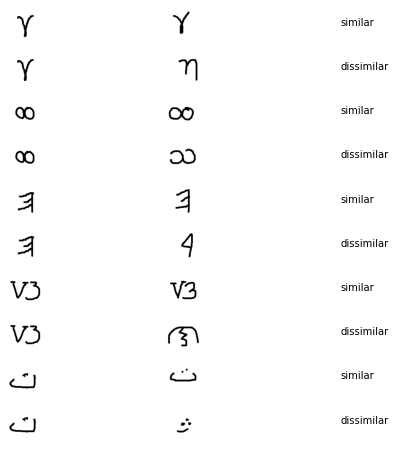

In [ ]:
#display train data
figure, axes = plt.subplots(10, 3, figsize=(8,8))
for i in range(10):
    axes[i, 0].imshow(cv2.imread(x_train[0][i], cv2.IMREAD_COLOR), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(cv2.imread(x_train[1][i], cv2.IMREAD_COLOR), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].text(0.5, 0.5, 'similar' if y_train[i] == 1 else 'dissimilar')
    axes[i, 2].axis('off')
    
plt.show()

In [ ]:
def generate_oneshot_test_trial(dataset, n_way=20):
    index = np.random.randint(0, len(dataset), 1)[0]
    alphabet = list(dataset.keys())[index]
    alphabet_items = list(dataset[alphabet].items())
    
    char_idx = np.random.randint(0, len(alphabet_items), 20)
    
    num_samples = len(alphabet_items[0][1])
    drawers = np.random.randint(0, num_samples, 2)

    
    test_images = []
    train_images = []
    for i in range(n_way):
        test_images.append(alphabet_items[char_idx[i]][1][drawers[0]])
        train_images.append(alphabet_items[char_idx[i]][1][drawers[1]])
    
    return (test_images, train_images)

In [ ]:
def load_images(names, shape):
    batch = np.empty((len(names), *shape), dtype=np.uint8)
    for i, name in enumerate(names):
        #batch[i,...] = np.expand_dims(cv2.imread(name, cv2.IMREAD_COLOR), axis=2)
        img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
        img = preprocess_input(cv2.resize(img, (shape[1], shape[0]))) #  preprocess_input needed because VGG16
        batch[i,...] = np.expand_dims(img, axis=2) 
    
    return batch

In [ ]:
def load_paired_images(names, shape):
    image1 = np.empty((len(names[0]), *shape), dtype=np.uint8)
    image2 = np.empty((len(names[1]), *shape), dtype=np.uint8)
    for i, name in enumerate(zip(names[0], names[1])):
        #image1[i,...] = np.expand_dims(cv2.imread(name[0], cv2.IMREAD_COLOR), axis=2)
        #image2[i,...] = np.expand_dims(cv2.imread(name[1], cv2.IMREAD_COLOR), axis=2)
        img1 = cv2.imread(name[0], cv2.IMREAD_GRAYSCALE)
        img1 = preprocess_input(cv2.resize(img1, (shape[1], shape[0])))
        img2 = cv2.imread(name[1], cv2.IMREAD_GRAYSCALE)
        img2 = preprocess_input(cv2.resize(img2, (shape[1], shape[0])))
        image1[i,...] = np.expand_dims(img1, axis=2)
        image2[i,...] = np.expand_dims(img2, axis=2)
    
    return [image1 , image2]

In [ ]:
def test_model(model, dataset=validset, rounds=1):
    # do it for n images
    total_corrects = 0
    for n in range(rounds):
        (test_image_names, train_image_names) = generate_oneshot_test_trial(dataset, 20)
        test_images = load_images(test_image_names, IMAGE_SHAPE)
        train_images = load_images(train_image_names, IMAGE_SHAPE)    
        
        corrects = 0
        for i in range(len(test_images)):
            images = np.tile(test_images[i], (len(train_images), 1, 1, 1))
            preds = model.predict([images, train_images])
            pred_idx = np.argmax(preds, axis=0)[0]
            # check they belong to same character or not
            test_char_name = test_image_names[i].split('/')[-2]
            pred_char_name = train_image_names[pred_idx].split('/')[-2]
            corrects += 1 if test_char_name == pred_char_name else 0
        
        total_corrects += corrects/len(train_image_names)
    
    return total_corrects/rounds

In [ ]:
def display_validation_test(model, dataset=validset):
    (test_image_names, train_image_names) = generate_oneshot_test_trial(dataset, 20)
    test_images = load_images(test_image_names, IMAGE_SHAPE)
    train_images = load_images(train_image_names, IMAGE_SHAPE)

    idx = np.random.randint(0, len(test_images))
    
    images = np.tile(test_images[idx], (len(train_images), 1, 1, 1))
    preds = model.predict([images, train_images])
    pred_idx = np.argmax(preds, axis=0)[0]
    print('Alphabet: {}'.format(test_image_names[idx].split('/')[-3]))
    
    # check they belong to same character
    test_char_name = test_image_names[idx].split('/')[-2]
    pred_char_name = train_image_names[pred_idx].split('/')[-2]
    correct = 1 if test_char_name == pred_char_name else 0
    plt.imshow(images[idx], cmap='gray')
    plt.axis('off')
    plt.annotate(test_image_names[idx].split('/')[-2], (0.0, 0.0), textcoords='axes fraction', size=10)
    plt.show()

    print('*'*100)
    print('Which of the following match above?')
    fig, axes = plt.subplots(4, 5, figsize=(10,10))
    ctr = 0
    print('Predicted index: {}, name: {}, actual: {}'.format(pred_idx, pred_char_name, test_char_name))
    
    for i in range(4):
        for j in range(5):
            class_name = train_image_names[ctr].split('/')[-2]
            axes[i, j].imshow(train_images[ctr], cmap='gray')
            axes[i, j].annotate(class_name, (0.0, 0.0), textcoords='axes fraction', size=10)
            axes[i, j].axis('off')                         
            ctr += 1

    plt.show()   
  

In [ ]:
def build_tl_model():
  input1 = Input(shape=(48,48,3))
  input2 = Input(shape=(48,48,3))

  base_model = VGG16(input_shape=(48,48,3), include_top=False, weights='imagenet') 
  base_model.trainable = False 

  model = tf.keras.models.Sequential([
    # Feature extractor 
    base_model,

    # Flatten and use the attribute given the question to build the dense part
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.sigmoid)
  ])
  encoded1 = model(input1)
  encoded2 = model(input2)
  L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
  L1_distance = L1_layer([encoded1, encoded2])
    
    
  prediction = Dense(1,activation='sigmoid')(L1_distance)
  siamese_model = Model(inputs=[input1,input2],outputs=prediction)

  return siamese_model

In [ ]:
siamese_model = build_tl_model()
siamese_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.00001), metrics=['accuracy'])
siamese_model.summary()  



58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         16815936    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)              

In [ ]:
image_shape = (48,48,3)
evaluate_every = 5000 # interval for evaluating on one-shot tasks
validate_every = 5000
batch_size = 32
epochs = 50000 # No. of training iterations

In [ ]:
print("Starting training process!")
print("-------------------------------------")

for i in range(epochs):
      (names,targets) = generate_oneshot_trial(trainset, batch_size)
      batch = load_paired_images(names, image_shape)  
      hist = siamese_model.train_on_batch(batch, targets)
      if i % evaluate_every == 0:
        print("Train Loss: {0}, Accuracy: {1}".format(*hist)) 

      if i % validate_every == 0:
        acc = test_model(siamese_model, dataset=validset, rounds =20)
        print('Validation acc: {}'.format(acc))
        

Starting training process!
-------------------------------------
Train Loss: 0.13832709193229675, Accuracy: 0.96875
Validation acc: 0.5999999999999999
Train Loss: 0.18691881000995636, Accuracy: 0.9375
Validation acc: 0.5250000000000001
Train Loss: 0.16607698798179626, Accuracy: 0.96875
Validation acc: 0.6425
Train Loss: 0.15530100464820862, Accuracy: 0.96875
Validation acc: 0.6125
Train Loss: 0.20447185635566711, Accuracy: 0.96875
Validation acc: 0.6225
Train Loss: 0.0948762446641922, Accuracy: 1.0
Validation acc: 0.6300000000000001
Train Loss: 0.13791310787200928, Accuracy: 1.0
Validation acc: 0.6225
Train Loss: 0.225645512342453, Accuracy: 0.9375
Validation acc: 0.6675
Train Loss: 0.09883525967597961, Accuracy: 1.0
Validation acc: 0.6400000000000001
Train Loss: 0.11971127986907959, Accuracy: 1.0
Validation acc: 0.6075000000000002


Alphabet: Burmese_(Myanmar)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


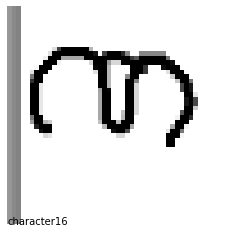

****************************************************************************************************
Which of the following match above?
Predicted index: 15, name: character16, actual: character16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


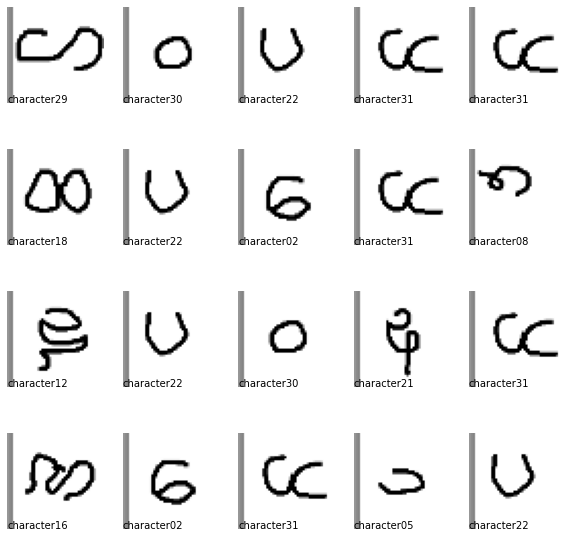

In [ ]:
display_validation_test(siamese_model)

In [ ]:
val_acc = test_model(siamese_model, rounds=30)
print('Validation accuracy is: {:.2f}'.format(val_acc))

Validation accuracy is: 0.68


Alphabet: Atemayar_Qelisayer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


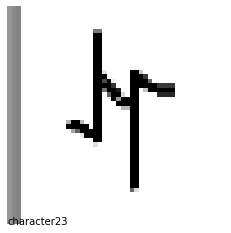

****************************************************************************************************
Which of the following match above?
Predicted index: 10, name: character22, actual: character23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


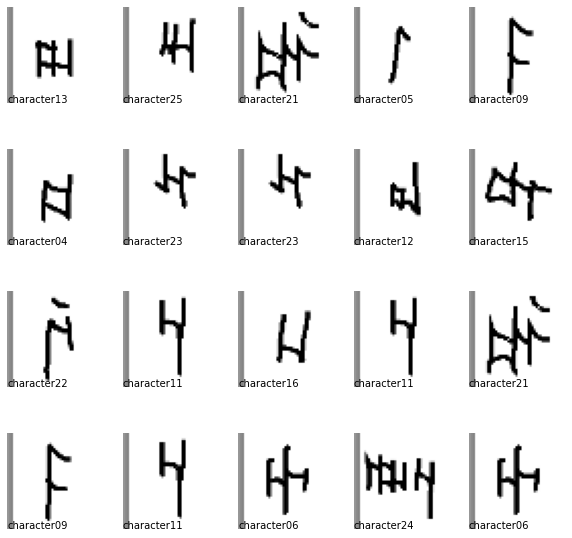

In [ ]:
test_alphabets = glob('{}/images_evaluation/*'.format(dataset_dir))
# create train and validation set
testset={}
for alph in test_alphabets:
    dirs = glob('{}/*'.format(alph))
    alphabet = {}
    for dirname in dirs:
        alphabet[dirname] = glob('{}/*'.format(dirname))
    testset[alph] = alphabet        

display_validation_test(siamese_model, testset)

In [ ]:
val_acc = test_model(siamese_model, dataset=testset, rounds=30)
print('Accuracy on testset is: {:.2f}'.format(val_acc))


Accuracy on testset is: 0.42
